<a href="https://colab.research.google.com/github/collinwa/MPCCA/blob/model_refactor/analysis_notebooks/analyze_mesa_parra_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import mpcca_collin.MPCCA.micca_model as micca
import mpcca_collin.MPCCA.model as model
import mpcca_collin.MPCCA.mp_simulation as mp_simulation

from scipy import stats
seed = 1337
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_printoptions(linewidth = 200)
np.set_printoptions(linewidth = 200)

In [ ]:
import importlib
importlib.reload(micca)
importlib.reload(model)
importlib.reload(mp_simulation)

<module 'mpcca_collin.MPCCA.mp_simulation' from '/gpfs/commons/home/bbrown/mpcca_collin/MPCCA/mp_simulation.py'>

In [ ]:
# methyl_data_save_fn="/gpfs/commons/projects/MESA/projects/mpcca/methyl_cca_collated.json"
# metab_data_save_fn="/gpfs/commons/projects/MESA/projects/mpcca/metab_cca_collated.json"
# exp_data_save_fn="/gpfs/commons/projects/MESA/projects/mpcca/exp_cca_collated.json"
# geno_data_save_fn="/gpfs/commons/projects/MESA/projects/mpcca/geno_cca_collated.json"
# protein_data_save_fn="/gpfs/commons/projects/MESA/projects/mpcca/protein_cca_collated.json"
# meta_df_save_fn="/gpfs/commons/projects/MESA/projects/mpcca/metadata_cca_collated.json"
# pheno_df_save_fn="/gpfs/commons/projects/MESA/projects/mpcca/phenotypes_cca_collated.json"

exam = '1'
methyl_data_save_fn='/gpfs/commons/projects/MESA/projects/mpcca/methyl_cca_collated_exam' + exam + '.json'
metab_data_save_fn='/gpfs/commons/projects/MESA/projects/mpcca/metab_cca_collated_exam' + exam + '.json'
exp_data_save_fn='/gpfs/commons/projects/MESA/projects/mpcca/exp_cca_collated_exam' + exam + '.json'
geno_data_save_fn='/gpfs/commons/projects/MESA/projects/mpcca/geno_cca_collated_exam' + exam + '.json'
protein_data_save_fn='/gpfs/commons/projects/MESA/projects/mpcca/protein_cca_collated_exam' + exam + '.json'
meta_df_save_fn='/gpfs/commons/projects/MESA/projects/mpcca/metadata_cca_collated_exam' + exam + '.json'
pheno_df_save_fn='/gpfs/commons/projects/MESA/projects/mpcca/phenotypes_cca_collated_exam' + exam + '.json'

In [ ]:
pheno_df = pd.read_json(pheno_df_save_fn)
meta_df = pd.read_json(meta_df_save_fn)
geno_data = pd.read_json(geno_data_save_fn)
metab_data = pd.read_json(metab_data_save_fn)
protein_data = pd.read_json(protein_data_save_fn)
exp_data = pd.read_json(exp_data_save_fn)
methyl_data = pd.read_json(methyl_data_save_fn)

n_inds = geno_data.shape[0]

In [ ]:
# TODO(brielin): Are genotype PCs weighted already?
geno_pca = micca.pca(torch.from_numpy(geno_data.values))
metab_pca = micca.pca(torch.from_numpy(metab_data.values))
protein_pca = micca.pca(torch.from_numpy(protein_data.values))
exp_pca = micca.pca(torch.from_numpy(exp_data.values))
methyl_pca = micca.pca(torch.from_numpy(methyl_data.values))

In [ ]:
print(n_inds, metab_pca.mp_dim, protein_pca.mp_dim, exp_pca.mp_dim, methyl_pca.mp_dim)

614 tensor(63) tensor(27) tensor(30) tensor(37)


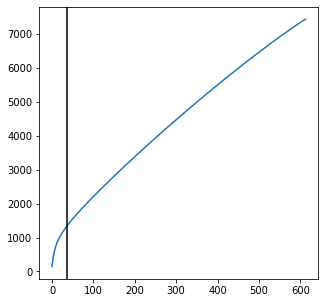

In [ ]:
# Cell to play with plotting SVs of initial data matrices
plt.rcParams['figure.figsize'] = (5, 5)
svs = methyl_pca.lam
sv_sum = torch.cumsum(svs, 0)
sns.lineplot(x=range(len(sv_sum)), y=sv_sum)
plt.axvline(x = methyl_pca.mp_dim, color = 'black')

In [ ]:
geno_ds = geno_pca.U*np.sqrt(n_inds-1)  # Not using MP dim, using given 11 PCs.
exp_ds = exp_pca.U[:, 0:exp_pca.mp_dim]*np.sqrt(n_inds-1)  # 33
methyl_ds = methyl_pca.U[:, 0:methyl_pca.mp_dim]*np.sqrt(n_inds-1)  # 49
metab_ds = metab_pca.U[:, 0:metab_pca.mp_dim]*np.sqrt(n_inds-1)  # 66
protein_ds = protein_pca.U[:, 0:protein_pca.mp_dim]*np.sqrt(n_inds-1)  # 29
datasets = [geno_ds, exp_ds, methyl_ds, metab_ds, protein_ds]

In [ ]:
meta_df = meta_df.sort_values(
    by=['sidno', 'NWDID', 'num_nans']).drop_duplicates(
        subset='NWDID').set_index('NWDID').loc[geno_data.index].drop(
            columns=['index', 'sidno', 'Metabolomics', 'Methylomics',
                     'Proteomics', 'Transcriptomics_PBMC', 'num_nans'])

In [ ]:
analysis_cols = ['Sex', 'Race', 'Age', 'bmi1c', 'RQS', 'adapter_contam_pct',
                 'seq_center', 'column_2', 'column_3', 'Summary.batch',
                 'Batch_scan', 'Bcell', 'CD4T', 'CD8T', 'Eos', 'Mono', 'Neu',
                 'NK', 'B cells', 'Plasma cells', 'T cells', 'NK cells',
                 'Monocytes', 'Macrophages', 'Dendritic cells', 'Mast cells',
                 'Eosinophils', 'Neutrophils']
meta_df = meta_df[analysis_cols]
meta_df_dummies = pd.get_dummies(meta_df)

tensor(14)


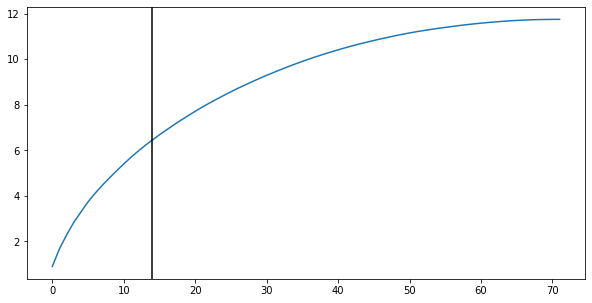

In [ ]:
# Fit all with Parra to make elbow plot
parra_res = micca.micca_nopc([geno_pca, exp_pca, methyl_pca, metab_pca, protein_pca], dimensions=[ds.shape[1] for ds in datasets])
# c_shared = sum(parra_res.rho > 0.2534)
c_shared = sum(parra_res.rho > 0.2381)
print(c_shared)
plt.rcParams['figure.figsize'] = (10, 5)
rho_parra = parra_res.rho[parra_res.rho > 0]
rho_sum = torch.cumsum(rho_parra, 0)
sns.lineplot(x=range(len(rho_sum)), y=rho_sum)
plt.axvline(x = c_shared, color = 'black')

In [ ]:
dimensions = [ds.shape[1] for ds in datasets]
c_private = [max(d - c_shared, 0) for d in dimensions]
parra_res = micca.micca_nopc([geno_pca, exp_pca, methyl_pca, metab_pca, protein_pca], dimensions=dimensions, c_shared=c_shared, c_private=c_private)

<AxesSubplot:>

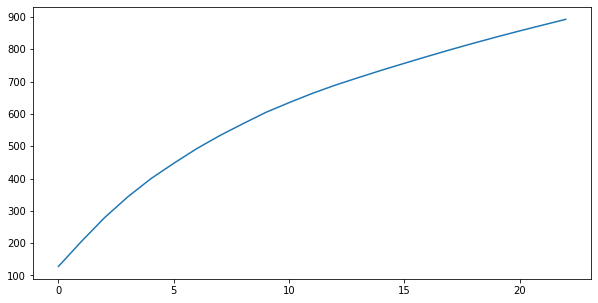

In [ ]:
# Simulations say all residual components are significant.
# Here is a sanity check plot
plt.rcParams['figure.figsize'] = (10, 5)
svs = parra_res.lam_private[2]
sv_sum = torch.cumsum(svs, 0)
sns.lineplot(x=range(len(sv_sum)), y=sv_sum)

In [ ]:
# Make heatmap fig using just Parra results.
plot_dims = [7, 13, 17 , 5]
data = torch.cat([parra_res.C_all] + [ C[:, 0:d] for C, d in zip(parra_res.C_private[1:], plot_dims)], 1).numpy()
colnames = ['Z_' + str(i) for i in range(len(parra_res.rho))] + \
    ['X_exp_' + str(i) for i in range(plot_dims[0])] + \
    ['X_methyl_' + str(i) for i in range(plot_dims[1])] + \
    ['X_metab_' + str(i) for i in range(plot_dims[2])] + \
    ['X_protein_' + str(i) for i in range(plot_dims[3])]
      # ['X_exp_' + str(i) for i in range(len(parra_res.lam_private[1]))] + \
    # ['X_methyl_' + str(i) for i in range(len(parra_res.lam_private[2]))] + \
    # ['X_metab_' + str(i) for i in range(len(parra_res.lam_private[3]))] + \
    # ['X_protein_' + str(i) for i in range(len(parra_res.lam_private[4]))]

ZX_df = pd.DataFrame(data, columns=colnames, index=meta_df_dummies.index)
parra_res_df = pd.concat([meta_df_dummies, ZX_df], axis=1)

In [ ]:
c_private

[0, tensor(16), tensor(23), tensor(49), tensor(13)]

<AxesSubplot:>

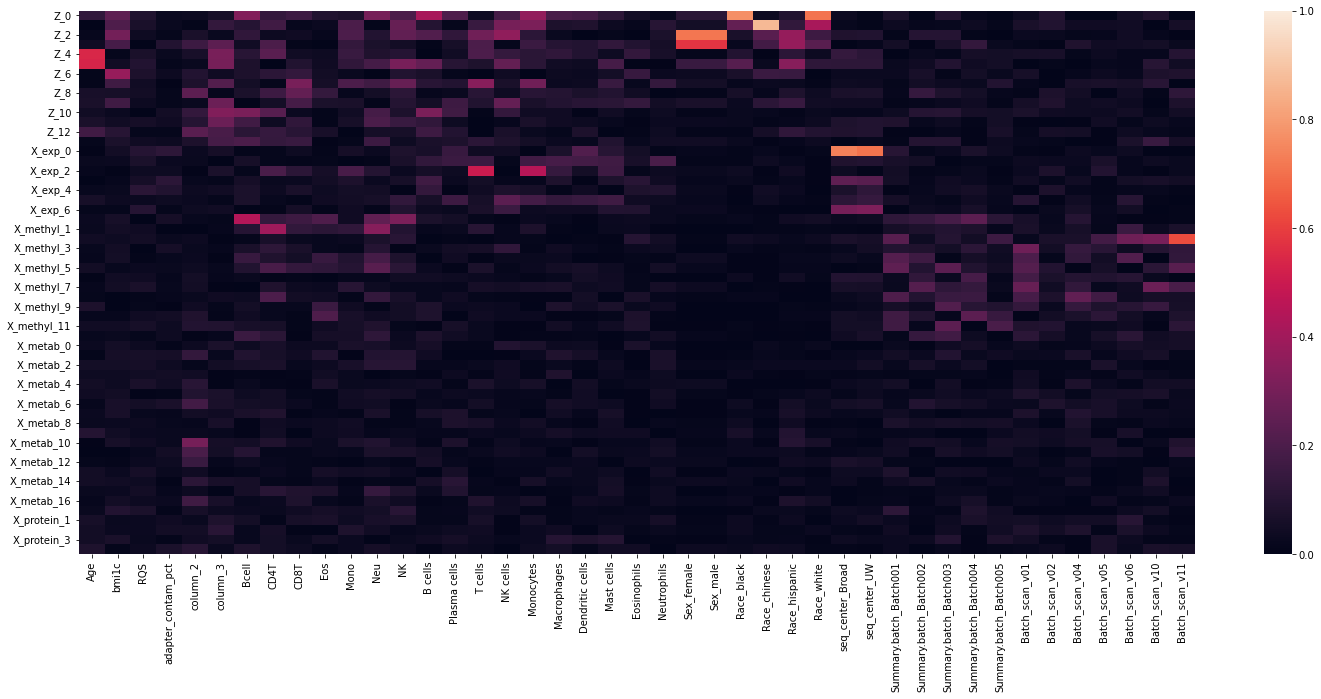

In [ ]:
plt.rcParams['figure.figsize'] = (25, 10)
data_cols = colnames
cor_cols = meta_df_dummies.columns
data = abs(np.corrcoef(parra_res_df.fillna(parra_res_df.mean())[data_cols], parra_res_df.fillna(parra_res_df.mean())[cor_cols], rowvar=False)[0:len(data_cols), len(data_cols):(len(data_cols)+len(cor_cols))])
space_cov_cor = pd.DataFrame(data, index=data_cols, columns=cor_cols)
sns.heatmap(space_cov_cor, vmin=0, vmax=1)

In [ ]:
parra_res_df['Race'] = meta_df.Race
parra_res_df['Sex'] = meta_df.Sex
parra_res_df['seq_center'] = meta_df.seq_center

<AxesSubplot:xlabel='Z_0', ylabel='Z_1'>

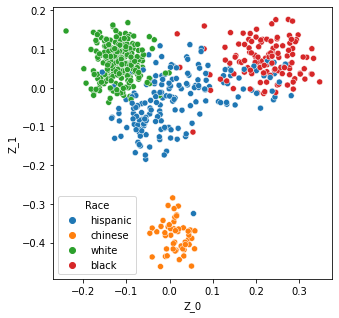

In [ ]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.scatterplot(data=parra_res_df, x='Z_0', y='Z_1', hue='Race')

<AxesSubplot:xlabel='Z_2', ylabel='Z_3'>

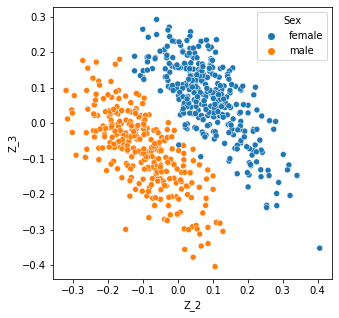

In [ ]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.scatterplot(data=parra_res_df, x='Z_2', y='Z_3', hue='Sex')

<AxesSubplot:xlabel='Z_4', ylabel='Z_5'>

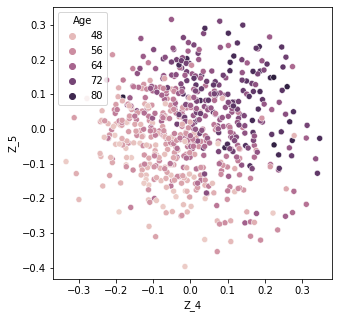

In [ ]:
plt.rcParams['figure.figsize'] = (5, 5)
sns.scatterplot(data=parra_res_df, x='Z_4', y='Z_5', hue='Age')

In [ ]:
pheno_df = pheno_df.loc[meta_df.index].drop(columns=['hba1c'])
pheno_df_dummies = pd.get_dummies(pheno_df)
parra_pheno_df = pd.concat([pheno_df_dummies, ZX_df], axis=1)

<AxesSubplot:>

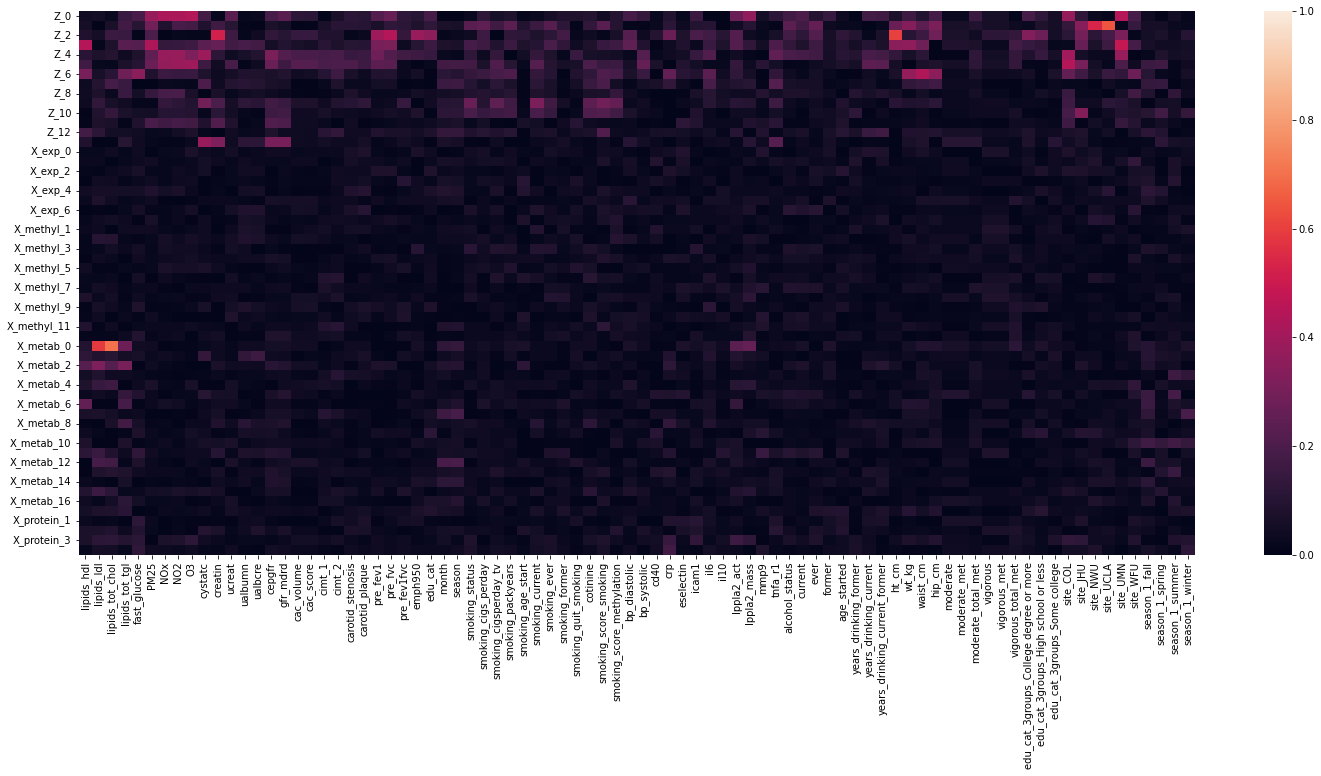

In [ ]:
plt.rcParams['figure.figsize'] = (25, 10)
data_cols = colnames
cor_cols = pheno_df_dummies.columns
data = abs(np.corrcoef(parra_pheno_df.fillna(parra_pheno_df.mean())[data_cols], parra_pheno_df.fillna(parra_pheno_df.mean())[cor_cols], rowvar=False)[0:len(data_cols), len(data_cols):(len(data_cols)+len(cor_cols))])
space_cov_cor = pd.DataFrame(data, index=data_cols, columns=cor_cols)
sns.heatmap(space_cov_cor, vmin=0, vmax=1)
# sns.heatmap(space_cov_cor)